In [291]:
import numpy as np
import numpy.random as rn
import math as m
import matplotlib.pyplot as plt
from __future__ import division
import time

G = 6.67e-11
R_jup = 7.785e+11
M_jup = 1.898e+27
M_sun = 1.989e+30
V_jup = m.sqrt(G*M_sun/R_jup)
R_earth = 1.496e+11 #Smallest R for an asteroid

In [292]:
nbodies = 1
dt = 3.16e+6 # approximately a year in time-step
t_end = 3.16e+6 * 11.8618 * 10
bodieslist = ["Sun", "Jupiter"]
initcond = np.zeros((nbodies,7))
positions = {}
positions["Sun"] = np.array([0,0,0,0,0,0,M_sun]) #x,y,z,vx, vy, vz
positions["Jupiter"] = np.array([R_jup,0,0,0,V_jup,0,M_jup])
asteroid_init()

print positions

{'Sun': array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.98900000e+30]), 'Body 1': array([  6.25041220e+11,  -4.47763879e+11,   0.00000000e+00,
         7.67890557e+03,   1.07191150e+04,   0.00000000e+00,
         0.00000000e+00]), 'Jupiter': array([  7.78500000e+11,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.30542222e+04,   0.00000000e+00,
         1.89800000e+27])}


In [293]:
def f12(Body1,Body2,position_1):
    if Body1 == Body2:
        return np.array([0,0,0])
    pos = position_1-positions[Body2][0:3]
    dist = np.linalg.norm(pos)
    return -G* positions[Body2][-1]*pos/(dist)**3

def force(Body1, position_1):
    F = 0
    for k in ["Jupiter", "Sun"]:
        F = F + f12(Body1, k, position_1)
    return F


def asteroid_init():
    
    for i in range(nbodies):
        theta = 2*m.pi*rn.random()        #Phase of the orbit
        r = rn.uniform(R_earth,R_jup)    #Radius of the asteroids between earth and jupiter orbit
        v = m.sqrt(G*M_sun/r) * rn.uniform(1, 1.01)
        bodieslist.append("Body "+str(i+1))
        positions[bodieslist[i+2]] = np.array([r*m.cos(theta),r*m.sin(theta),0,v*m.cos(theta+m.pi/2),v*m.sin(theta+m.pi/2),0, 0])
        
    

In [294]:
def RK4_gravitational(Body, dt):
    
    k1 = np.concatenate((positions[Body][3:6], force(Body, positions[Body][:3]))) * dt
    k2 = np.concatenate((positions[Body][3:6] + k1[3:] * 0.5, force(Body, positions[Body][:3]  + k1[:3] * 0.5))) * dt
    k3 = np.concatenate((positions[Body][3:6] + k2[3:] * 0.5, force(Body, positions[Body][:3]  + k2[:3] * 0.5))) * dt
    k4 = np.concatenate((positions[Body][3:6] + k3[3:], force(Body, positions[Body][:3]  + k3[:3]))) * dt
    positions[Body][:6] = positions[Body][:6] + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
    
    return positions[Body]


def EulerCromer_gravitational(Body, dt):
    
    v_np1 = positions[Body][3:6] + force(Body, positions[Body][:3]) * dt
    x_np1 = positions[Body][:3] + v_np1 * dt
    positions[Body][:6] = np.concatenate((x_np1, v_np1))
    
    return positions[Body]


def integrator(t_end, dt, int_type):
    for i in xrange(int(t_end/dt)):
        temporalbodielist = bodieslist
        for j, Body in enumerate(temporalbodielist):
            if int_type == 'RK4':
                positions[Body] = RK4_gravitational(Body, dt)
            else:
                positions[Body] = EulerCromer_gravitational(Body, dt)
            #Condition to get rid of asteroids flying away
            if positions[Body][0] > 3*R_jup or positions[Body][1] > 3* R_jup or positions[Body][0] < -3*R_jup or positions[Body][1] < -3* R_jup:  #Eliminating from the list asteroids scaping
                bodieslist.remove(Body)
        
    return positions

time_1 = time.time()
print integrator(t_end, dt)
# plt.show()
print 'Computation time: ' + str(time.time() - time_1) + ' s'

In [296]:
def E_potential(Body1,Body2,position_1):
    if Body1 == Body2:
        return np.array([0,0,0])
    pos = position_1-positions[Body2][0:3]
    dist = np.linalg.norm(pos)
    return -G* positions[Body1][-1] * positions[Body2][-1]/(dist)

def energy_calculator(Body1, position_1):
    E_pot = 0
    for k in ["Jupiter", "Sun"]:
        E_pot = E_pot + E_potential(Body1, k, position_1)
    E_kin = 0.5 * positions[Body1][-1] * (positions[Body1][3]**2 + positions[Body1][4]**2 + positions[Body1][5]**2)
    return E_pot + E_kin

def energy_tester():
    dt = 1e+6
    intervals = np.linspace(1e+2, 1e+4, 10)
    for int_type in ['RK4', 'EulerCromer']:
        for i in intervals:
            E_total = 0
            for j, Body in enumerate(bodieslist):
                if int_type == 'RK4':
                    positions[Body] = RK4_gravitational(Body, dt)
                else:
                    positions[Body] = EulerCromer_gravitational(Body, dt)
                E_total += energy_calculator(Body, positions[Body][:3])
    
        E_
        


[   100.   1200.   2300.   3400.   4500.   5600.   6700.   7800.   8900.
  10000.]


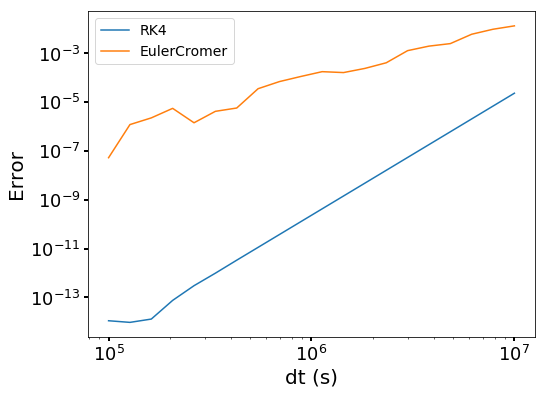

In [295]:
def accuracy_tester():
    t_kep = 2 * m.pi * R_jup**1.5 / m.sqrt(G*M_sun) # keplerian period jupiter
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    errors = np.zeros(20)
    dts = np.logspace(5,7,20)
    for int_type in ['RK4', 'EulerCromer']:
        for i, dt in enumerate(dts):
            positions["Sun"] = np.array([0,0,0,0,0,0,M_sun]) #x,y,z,vx, vy, vz
            positions["Jupiter"] = np.array([R_jup,0,0,0,V_jup,0,0]) # massless jupiter
            new_positions = integrator(t_kep, dt, int_type)
            r_obs = m.sqrt(new_positions['Jupiter'][0]**2 + new_positions['Jupiter'][1]**2 + new_positions['Jupiter'][2]**2)
            errors[i] = abs((r_obs - R_jup) / R_jup)
        ax.plot(dts, errors, label=int_type)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('dt (s)', fontsize=20)
    ax.set_ylabel('Error', fontsize=20)
    ax.tick_params(width=2, length=4, labelsize=18)
    ax.legend(prop={'size': 14})
    plt.show()
    
# accuracy_tester()